## SIMULAÇÃO LINHA ATUAL 

IMPORTS

In [1]:
import pandas as pd
import simpy
import os
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
import matplotlib.patches as mpatches
from datetime import date, timedelta
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas

### ETAPA 1 - Obtendo informações de tempo do Yamazumi

In [2]:


# OBTENDO TEMPOS POR ATIVIDADES DOS ARQUIVOS YAMAZUMI 
def get_process_times_from_csv(arquivo):
    """Lê um CSV Yamazumi, extrai os tempos por atividade e retorna um dicionário {atividade: tempo_em_segundos}."""
    
    def converter_tempo_para_segundos(tempo_str):
        if pd.isna(tempo_str) or not isinstance(tempo_str, str):
            return 0
        parts = str(tempo_str).split(':')
        try:
            if len(parts) == 3:
                h, m, s = map(int, parts)
                return h * 3600 + m * 60 + s
            elif len(parts) == 2:
                m, s = map(int, parts)
                return m * 60 + s
        except Exception:
            return 0
        return 0

    if not os.path.exists(arquivo):
        return {}

    df = pd.read_csv(arquivo, header=5, sep=';', encoding='latin1', on_bad_lines='skip')

    def normalizar_coluna(col):
        col = unidecode(col)
        col = col.upper()
        col = re.sub(r"[\"\'().\-\/]", "", col)
        col = re.sub(r"\s+", "_", col)
        return col.strip("_")

    df.columns = [normalizar_coluna(col) for col in df.columns]

    class_col = next((col for col in df.columns if 'CLASSIFICA' in col), None)
    if not class_col:
        return {}

    total_row = df[df[class_col] == 'Total'].copy()
    if total_row.empty:
        return {}

    start_col = df.columns.get_loc(class_col) + 1
    end_col = len(df.columns)
    try:
        end_col = df.columns.get_loc('COLUNA1')
    except KeyError:
        pass

    colunas_postos = df.columns[start_col:end_col]
    tempos_totais = total_row[colunas_postos].dropna(axis=1, how='all')
    tempos_formatados = tempos_totais.melt(var_name='Atividade', value_name='Tempo_str')
    tempos_formatados['Tempo_segundos'] = tempos_formatados['Tempo_str'].apply(converter_tempo_para_segundos)
    
    return pd.Series(tempos_formatados.Tempo_segundos.values, index=tempos_formatados.Atividade).to_dict()



In [3]:
get_process_times_from_csv("Yamazumi - Accelo.csv")

{'ARREFEC': 316,
 'DIESEL': 253,
 'REAPERTO': 235,
 'ESTEPE': 290,
 'PNEU_LD': 250,
 'PNEU_LE': 250,
 'APERTO_LD': 304,
 'APERTO_LE': 304,
 'GRADE': 270,
 'MECACNICA_1': 194,
 'MECACNICA_2': 194,
 'ELACTRICA_1': 357,
 'ELACTRICA_2': 357,
 'CONTROLE': 265,
 'MOTORISTA': 266,
 'QUIS': 270}

### ETAPA 02: Criando dicionário de tempos por posto

##### Configuração perna 1: 
19 operadores no total sendo 1 por atividade, com excessões: 
- DIESEL - 30A  
- ARREFEC - 31A  
- REAPERTO - 32A  
- 5AA_RODA - 32C (só ATP)  
- ESTEPE - 32C  
- PNEU_LE + PNEU_LD - 33A (2 operadores)  
- APERTO_LE + APERTO_LD - 34A (2 operadores)  
- GRADE- 34A  
- MECACNICA_1 + MECACNICA_2 - Início: 34A; Fim: 38 (2 operadores)  
- ELECTRICA_1 + ELECTRICA_2 - Início: 32A; Fim: 33A (2 operadores)  
- CONTROLE - 34A  
- MOTORISTA - 38  
- QUIS - 38  




##### Configuração perna 2:
13 operadores no total sendo 1 por atividade, com excessões: 
- PASSADISASSO - 30B 
- ABASTECIMENTO - 31B   
- CHINELEIRA - 32B  
- 5AA_RODA - 32D  
- PNEU_LE + PNEU_LD - 33B (2 operadores)  
- PARALAMA_LD + PARALAMA_LE - 34B (1 op)  
Paralama e pneu é feito ao mesmo tempo, assim, tempo paralama conta como 1
- CONTROLE - 34B 
- ELACTRICA_I + ELACTRICA_II + ELACTRICA_III - Início: 33B; Fim: 39 (3 operadores)  
Na elétrica, podemos considerar como se 1 operador fizesse 1 atvidade total distribuída pelos 3 postos  


In [4]:

# --- Dicionários ---
MODELOS_CSV = {
    "Accelo": {"baumuster": ["C951102", "C951104", "C951111"], "perna": 1, "tempos": "Yamazumi - Accelo.csv"},
    "Atego": {"baumuster":["C951500", "C951501", "C951511", "C951514", "C951530", "C951544"],"perna": 1, "tempos":"Yamazumi - Atego.csv"},
    "Atego (ATP)":{"baumuster": ["C968403", "C968114"], "perna": 1, "tempos":"Yamazumi - ATP.csv"}, 
    "Actros":{"baumuster": ["C963400", "C963403", "C963411", "C963414", "C963424", "C963425"], "perna": 2, "tempos":"Yamazumi - Actros.csv"},
    "Arocs": {"baumuster":["C964016", "C964216", "C964231", "C964416"], "perna": 2, "tempos":"Yamazumi - Arocs.csv"},
    "Axor (ATP +)":{"baumuster": ["C968150", "C968450", "C968453", "C968461", "C968475"], "perna":2, "tempos": "Yamazumi - Actros.csv"}
}

ATIVIDADES_P1 = {'DIESEL':{'postos':['30A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ARREFEC':{'postos':['31A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'REAPERTO':{'postos':['32A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              '5AA_RODA':{'postos':['32C'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ESTEPE':{'postos':['32C'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'APERTO_LE':{'postos':['32C'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'PNEU_LD':{'postos':['33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1}, 
              'PNEU_LE':{'postos':['33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'APERTO_LD':{'postos':['34A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'GRADE':{'postos':['34A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'MECACNICA_1':{'postos':['34A','38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'MECACNICA_2':{'postos':['34A','38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ELACTRICA_1':{'postos':['32A','32C','33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ELACTRICA_2':{'postos':['32A','32C','33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'CONTROLE':{'postos':['34A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'MOTORISTA':{'postos':['38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'QUIS':{'postos':['38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              }

ATIVIDADES_P2 = {'PASSADISASSO':{'postos':['30B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ABASTECIMENTO':{'postos':['31B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'CHINELEIRA':{'postos':['32B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              '5AA_RODA': {'postos':['32D'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'PNEU_LD':{'postos':['33B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1}, 
              'PNEU_LE':{'postos':['33B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'PARALAMA_LD': {'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},#mesmo operador que o de aperto_ld e le
              'PARALAMA_LE':{'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'CONTROLE': {'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ELACTRICA_I':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ELACTRICA_II':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ELACTRICA_III':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1}
              }


In [5]:
def gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
    """
    Gera o dicionário POSTOS por modelo com tempos por posto a partir das regras fixas por perna.
    - Respeita MODELOS_CSV['perna'] como lista (ex.: [1] ou [1,2]).
    - Se um modelo tiver mais de uma perna, cria chaves separadas, e.g. "Atego (ATP) P1" e "Atego (ATP) P2".
    - Em cada perna, aplica exatamente as fórmulas descritas pelo usuário, dividindo sempre por 'operadores'
      antes de combinar (somar, fazer médias e dividir pelos fatores).
    - Campo 'perna' no POSTOS sai como lista, ex.: {"tempo_tot": ..., "perna": [1]}.
    """

    # Ordem de exibição dos postos
    ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
    ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']

    POSTOS = {}

    # Helpers ----------------------------
    def _coerce_pernas(pernas):
        """Garante que 'perna' venha como lista."""
        if isinstance(pernas, int):
            return [pernas]
        if isinstance(pernas, (list, tuple)):
            return list(pernas)
        # fallback (caso venha outro iterável)
        return list(pernas)

    def t(atividade, tempos, ativ_dict):
        """Tempo da atividade já dividido pelo nº de operadores (se existir)."""
        if atividade not in ativ_dict:
            return 0.0
        ops = ativ_dict[atividade].get('operadores', 1) or 1
        return (tempos.get(atividade, 0.0)) / ops

    def avg(vals):
        vals = [v for v in vals if v is not None]
        return (sum(vals) / len(vals)) if vals else 0.0

    # ------------------------------------

    for modelo, dados_modelo in MODELOS_CSV.items():
        pernas_modelo = _coerce_pernas(dados_modelo.get("perna", []))
        arquivo = dados_modelo["tempos"]

        # tempos por atividade vindo do Yamazumi
        tempos_atividade = get_process_times_from_csv(arquivo)
        if not tempos_atividade:
            # Se não conseguiu ler tempos, só pula o modelo
            continue

        for perna_atual in pernas_modelo:
            if perna_atual == 1:
                ativ = ATIVIDADES_P1
                ordem = ordem_P1

                # --------- Regras PERNA 1 ---------
                # 30A --> DIESEL/num operadores
                p_30A = t('DIESEL', tempos_atividade, ativ)

                # 31A --> ARREFEC/num operadores
                p_31A = t('ARREFEC', tempos_atividade, ativ)

                # 32A --> REAPERTO/op + (EL1/op + EL2/op)/2/3
                el_mix_p1 = avg([t('ELACTRICA_1', tempos_atividade, ativ),
                                 t('ELACTRICA_2', tempos_atividade, ativ)]) / 3.0
                p_32A = t('REAPERTO', tempos_atividade, ativ) + el_mix_p1

                # 32C --> ESTEPE/op + APERTO_LE/op + 5AA_RODA/op + (EL1/op + EL2/op)/2/3
                p_32C = (
                    t('ESTEPE', tempos_atividade, ativ) +
                    avg([t('APERTO_LE', tempos_atividade, ativ), t('5AA_RODA', tempos_atividade, ativ)]) +
                    el_mix_p1
                )
                # print(p_32C)
                # print(t('ESTEPE', tempos_atividade, ativ))
                # print(t('5AA_RODA', tempos_atividade, ativ))
                # print(t('APERTO_LE', tempos_atividade, ativ))
                # print(el_mix_p1)
                # print(avg([t('APERTO_LE', tempos_atividade, ativ), t('5AA_RODA', tempos_atividade, ativ)]))
                # print('-----------')
                

                # 33A --> (PNEU_LE/op + PNEU_LD/op)/2 + (EL1/op + EL2/op)/2/3
                pneus_p1 = avg([t('PNEU_LE', tempos_atividade, ativ),
                                t('PNEU_LD', tempos_atividade, ativ)])
                p_33A = pneus_p1 + el_mix_p1

                # 34A --> APERTO_LD/op + GRADE/op + (MEC1/op + MEC2/op)/2/2
                mec_avg_p1 = avg([t('MECACNICA_1', tempos_atividade, ativ),
                                  t('MECACNICA_2', tempos_atividade, ativ)]) / 2.0
                p_34A = t('APERTO_LD', tempos_atividade, ativ) + t('GRADE', tempos_atividade, ativ) + mec_avg_p1

                # 38 --> MOTORISTA/op + QUIS/op + (MEC1/op + MEC2/op)/2/2
                p_38 = t('MOTORISTA', tempos_atividade, ativ) + t('QUIS', tempos_atividade, ativ) + mec_avg_p1

                tempos_por_posto = {
                    '30A': p_30A,
                    '31A': p_31A,
                    '32A': p_32A,
                    '32C': p_32C,
                    '33A': p_33A,
                    '34A': p_34A,
                    '38' : p_38
                }

            elif perna_atual == 2:
                ativ = ATIVIDADES_P2
                ordem = ordem_P2

                # --------- Regras PERNA 2 ---------
                # 30B --> PASSADISASSO/op
                p_30B = t('PASSADISASSO', tempos_atividade, ativ)

                # 31B --> ABASTECIMENTO/op
                p_31B = t('ABASTECIMENTO', tempos_atividade, ativ)

                # 32B --> CHINELEIRA/op
                p_32B = t('CHINELEIRA', tempos_atividade, ativ)

                # 32D --> 5AA_RODA/op
                p_32D = t('5AA_RODA', tempos_atividade, ativ)

                # Elétrica (I+II+III): ((EL_I/op + EL_II/op + EL_III/op)/2)/3
                el_sum = sum([
                    t('ELACTRICA_I', tempos_atividade, ativ),
                    t('ELACTRICA_II', tempos_atividade, ativ),
                    t('ELACTRICA_III', tempos_atividade, ativ)
                ])
                el_share = (el_sum / 2.0) / 3.0

                # 33B --> (PNEU_LE/op + PNEU_LD/op)/2 + el_share
                pneus_p2 = avg([t('PNEU_LE', tempos_atividade, ativ),
                                t('PNEU_LD', tempos_atividade, ativ)])
                p_33B = pneus_p2 + el_share

                # 34B --> ((PARALAMA_LD+PARALAMA_LE)/2 + CONTROLE/op + el_share)
                paralamas_avg = avg([t('PARALAMA_LD', tempos_atividade, ativ),
                                     t('PARALAMA_LE', tempos_atividade, ativ)])
                p_34B = paralamas_avg + t('CONTROLE', tempos_atividade, ativ) + el_share

                # 39 --> el_share
                p_39 = el_share

                tempos_por_posto = {
                    '30B': p_30B,
                    '31B': p_31B,
                    '32B': p_32B,
                    '32D': p_32D,
                    '33B': p_33B,
                    '34B': p_34B,
                    '39' : p_39
                }

            else:
                # perna inválida (só 1 e 2 são suportadas)
                continue

            # Monta o dicionário de saída do modelo nessa perna
            postos_ordenados = {}
            for posto in ordem:
                if posto in tempos_por_posto and tempos_por_posto[posto] > 0:
                    postos_ordenados[posto] = {"tempo_tot": tempos_por_posto[posto], "perna": [perna_atual]}

            # Se o modelo tem mais de uma perna, cria nomes distintos
            chave_modelo = modelo if len(pernas_modelo) == 1 else f"{modelo} P{perna_atual}"
            POSTOS[chave_modelo] = postos_ordenados

    return POSTOS


In [6]:
POSTOS= gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv)

In [7]:
POSTOS

{'Accelo': {'30A': {'tempo_tot': 253.0, 'perna': [1]},
  '31A': {'tempo_tot': 316.0, 'perna': [1]},
  '32A': {'tempo_tot': 354.0, 'perna': [1]},
  '32C': {'tempo_tot': 561.0, 'perna': [1]},
  '33A': {'tempo_tot': 369.0, 'perna': [1]},
  '34A': {'tempo_tot': 671.0, 'perna': [1]},
  '38': {'tempo_tot': 633.0, 'perna': [1]}},
 'Atego': {'30A': {'tempo_tot': 314.0, 'perna': [1]},
  '31A': {'tempo_tot': 314.0, 'perna': [1]},
  '32A': {'tempo_tot': 414.0, 'perna': [1]},
  '32C': {'tempo_tot': 544.5, 'perna': [1]},
  '33A': {'tempo_tot': 428.0, 'perna': [1]},
  '34A': {'tempo_tot': 646.0, 'perna': [1]},
  '38': {'tempo_tot': 633.0, 'perna': [1]}},
 'Atego (ATP)': {'30A': {'tempo_tot': 326.0, 'perna': [1]},
  '31A': {'tempo_tot': 330.0, 'perna': [1]},
  '32A': {'tempo_tot': 677.0, 'perna': [1]},
  '32C': {'tempo_tot': 815.0, 'perna': [1]},
  '33A': {'tempo_tot': 376.0, 'perna': [1]},
  '34A': {'tempo_tot': 650.0, 'perna': [1]},
  '38': {'tempo_tot': 633.0, 'perna': [1]}},
 'Actros': {'30B': {'

### ETAPA 03: Processamento da simulação 

In [8]:

 
TAKT_TIME = 5.5 * 60

TURN_DURATION = 14 * 3600
 
# defina a granularidade (1.0 = segundos; use 0.1 p/ décimos, 0.01 p/ centésimos)

TIME_GRID = 1.0
 
def q(t, base=TIME_GRID):

    # alinha t para a grade de tempo definida

    return round(t / base) * base
 
def processar_modelo(env, nome, modelo_nome, perna, postos_dict, recursos, log):

    for idx, (posto, dados) in enumerate(postos_dict.items()):

        tempo_tot = float(dados["tempo_tot"])

        recurso = recursos[posto]
 
        # requisita recurso

        req = recurso.request()

        instante_requisicao = env.now

        yield req
 
        # início real no posto (após obter o recurso), já quantizado

        inicio = q(env.now)

        tempo_proc = q(tempo_tot)
 
        # executa processamento com tempo quantizado

        yield env.timeout(tempo_proc)

        fim = q(env.now)
 
        # libera o recurso explicitamente

        recurso.release(req)
 
        # registra

        log.append({

            "modelo": modelo_nome,

            "nome": nome,

            "posto": posto,

            "perna": perna,

            "fila": max(0.0, inicio - q(instante_requisicao)),  # espera antes de iniciar

            "processo": tempo_proc,                              # tempo de posto (sem fila)

            "entrada": inicio,                                   # início no posto

            "saida": fim,                                        # fim no posto

            "duracao": fim - inicio                              # deve == tempo_proc (dentro da grade)

        })
 
def simulacao_linha(sequencia_modelos, MODELOS_CSV, resultado, TAKT_TIME, TURN_DURATION):

    env = simpy.Environment()
 
    # log local por execução

    log_entrada_saida = []
 
    # recursos por posto

    recursos = {}

    for modelo in resultado.values():

        for posto in modelo.keys():

            if posto not in recursos:

                recursos[posto] = simpy.Resource(env, capacity=1)
 
    # controles de entrada

    ultimo_tempo_entrada_global = 0.0

    disponibilidade_postos = {}
 
    def alimentador(env):

        nonlocal ultimo_tempo_entrada_global
 
        for i, baumuster in enumerate(sequencia_modelos):

            # resolve modelo e perna

            modelo_nome, perna = None, None

            for nome, dados in MODELOS_CSV.items():

                if baumuster in dados["baumuster"]:

                    modelo_nome = nome

                    perna = dados["perna"]

                    break

            if modelo_nome is None:

                continue
 
            postos_dict = resultado[modelo_nome]

            primeiro_posto = next(iter(postos_dict))

            tempo_ciclo_primeiro_posto = float(postos_dict[primeiro_posto]["tempo_tot"])
 
            if primeiro_posto not in disponibilidade_postos:

                disponibilidade_postos[primeiro_posto] = 0.0
 
            # calcula a próxima entrada possível e quantiza

            tempo_disponivel_posto = disponibilidade_postos[primeiro_posto]

            entrada_sugerida = q(max(

                env.now,

                ultimo_tempo_entrada_global + TAKT_TIME,

                tempo_disponivel_posto

            ))
 
            # espera até a janela de entrada

            atraso = max(0.0, entrada_sugerida - env.now)

            if atraso:

                yield env.timeout(atraso)
 
            # atualiza os controles (já quantizados)

            ultimo_tempo_entrada_global = entrada_sugerida

            disponibilidade_postos[primeiro_posto] = q(entrada_sugerida + tempo_ciclo_primeiro_posto)
 
            # instancia o processo do veículo

            env.process(processar_modelo(

                env=env,

                nome=f"{modelo_nome}_{i}",

                modelo_nome=modelo_nome,

                perna=perna,

                postos_dict=postos_dict,

                recursos=recursos,

                log=log_entrada_saida

            ))
 
    env.process(alimentador(env))

    env.run(until=q(TURN_DURATION))
 
    # opcional: força colunas numéricas a respeitar a mesma grade na saída

    df = pd.DataFrame(log_entrada_saida)

    for col in ["fila", "processo", "entrada", "saida", "duracao"]:

        if col in df.columns:

            df[col] = df[col].apply(q)
 
    return df
 

### ETAPA 04 : Criando funções de resposta gráfica  

In [9]:
def plot_duracao_media_por_posto(df_log):
    """
    Gera gráficos de barras da duração média por posto para cada perna, com base em df_log.
    Retorna uma lista com duas figuras.
    """
    import matplotlib.pyplot as plt

    df_log = df_log.copy()
    df_log["duracao_min"] = df_log["duracao"] / 60  # segundos → minutos
    figs = []

    for perna, cor in zip([1, 2], ["turquoise", "purple"]):
        media_perna = df_log[df_log["perna"] == perna].groupby("posto")["duracao_min"].mean()

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(media_perna.index, media_perna.values, color=cor)
        ax.set_title(f"Duração média por posto - Perna {perna}")
        ax.set_ylabel("Duração (min)")
        ax.set_xlabel("Posto")
        ax.set_xticklabels(media_perna.index, rotation=45)
        fig.tight_layout()

        figs.append(fig)

    return figs


In [10]:
def plot_modelos_por_perna(df_log):
    """
    Plota gráfico de barras com a quantidade de modelos únicos produzidos por perna.
    """
    modelos_por_perna = df_log.groupby("perna")["nome"].nunique()
    fig = plt.figure(figsize=(10, 5))
    modelos_por_perna.plot(kind='bar', color='skyblue')
    plt.title("Modelos Produzidos por Perna")
    plt.xlabel("Perna")
    plt.ylabel("Quantidade de Modelos")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return fig


In [11]:
def plot_modelos_produzidos(df_log):
    """
    Plota gráfico de barras com a quantidade de veículos produzidos por tipo de modelo.
    Retorna a figura.
    """
    modelos_produzidos = df_log.groupby("modelo")["nome"].nunique().sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(10, 8))
    bars = ax.bar(modelos_produzidos.index, modelos_produzidos.values, color='navy')

    for i, valor in enumerate(modelos_produzidos):
        ax.text(i, valor + 0.2, f"{valor}", ha='center', va='bottom', fontsize=9)

    ax.set_title("Modelos Produzidos no Turno")
    ax.set_xlabel("Modelo")
    ax.set_ylabel("Quantidade de Veículos")
    ax.set_xticklabels(modelos_produzidos.index, rotation=45)

    fig.tight_layout()
    return fig


In [12]:
def plot_ocupacao_por_modelo_heatmap(df_log, TURN_DURATION):
    """
    Plota heatmaps da eficiência por modelo e posto para cada perna, 
    ponderando pelo número de unidades produzidas por modelo.
    Retorna uma lista de figuras para salvar ou manipular externamente.
    """

    df = df_log.copy()
    df["duracao_min"] = df["duracao"] / 60

    # 1. Soma do tempo por modelo/posto/perna
    soma_tempo = df.groupby(["perna", "modelo", "posto"])["duracao_min"].sum().reset_index()

    # 2. Quantidade de veículos por modelo e perna
    qtd_modelos = df.groupby(["perna", "modelo"])["nome"].nunique().reset_index().rename(columns={"nome": "qtd"})

    # 3. Merge das duas tabelas
    eficiencia = pd.merge(soma_tempo, qtd_modelos, on=["perna", "modelo"], how="left")

    # 4. Tempo médio por veículo
    eficiencia["duracao_media"] = eficiencia["duracao_min"] / eficiencia["qtd"]

    # 5. Eficiência = tempo médio / turno
    eficiencia["eficiencia"] = (eficiencia["duracao_media"] / TURN_DURATION) * 100

    figs = []

    for perna in [1, 2]:
        data = eficiencia[eficiencia["perna"] == perna]

        modelos_perna = df[df["perna"] == perna]["modelo"].unique()
        postos_perna = df[df["perna"] == perna]["posto"].unique()

        full_index = pd.MultiIndex.from_product(
            [modelos_perna, postos_perna], names=["modelo", "posto"]
        )

        data = data.set_index(["modelo", "posto"]).reindex(full_index).reset_index()
        data["eficiencia"] = data["eficiencia"].fillna(0)

        heatmap_data = data.pivot(index="posto", columns="modelo", values="eficiencia")

        fig, ax = plt.subplots(figsize=(6, 5))
        sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="RdPu", cbar=True, ax=ax)
        ax.set_title(f"Porcentagem de ocupação dos modelos por posto - Perna {perna}")
        ax.set_ylabel("Posto")
        ax.set_xlabel("Modelo")
        fig.tight_layout()
        
        figs.append(fig)  # adiciona a figura corretamente (não None)

    return figs


In [13]:

def plot_sequencia_modelos_heatmap(df_log):
    # 1. Organiza a sequência e calcula a ordem de entrada
    modelos_completos = df_log.groupby("nome").agg(
        modelo=("modelo", "first"),
        perna=("perna", "first"),
        entrada_total=("entrada", "min"),
        saida_total=("saida", "max")
    ).reset_index()

    modelos_completos["ordem"] = modelos_completos["entrada_total"].rank(method='first').astype(int)

    # 2. Cria tabela pivô com modelos por ordem de entrada e perna
    pivot = modelos_completos.pivot_table(index="perna", columns="ordem", values="modelo", aggfunc='first')

    # 3. Mapeia modelos para inteiros
    unique_modelos = pd.Series(pivot.values.ravel()).dropna().unique()
    modelo_to_int = {m: i for i, m in enumerate(sorted(unique_modelos))}
    int_to_modelo = {i: m for m, i in modelo_to_int.items()}

    pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))

    # 4. Paleta de cores
    palette = sns.color_palette("tab20", n_colors=len(modelo_to_int))
    cores = {modelo: palette[i] for modelo, i in modelo_to_int.items()}


    # 5. Heatmap
    fig = plt.figure(figsize=(20, 5))
    # plt.pto
    sns.heatmap(pivot_num, cmap=palette, cbar=False, linewidths=0.5)
    plt.title("Sequência de Modelos na Linha (por posição)")
    plt.xlabel("Ordem de Entrada")
    plt.ylabel("Perna")
    plt.tight_layout()

    # 6. Legenda
    handles = [mpatches.Patch(color=cores[m], label=m) for m in sorted(cores)]
    plt.legend(
        handles=handles,
        title="Modelo",
        bbox_to_anchor=(1.01, 1),
        loc="upper left",
        borderaxespad=0.
    )
    plt.show()
    
    return fig


In [14]:
# def plot_boxplot_tempo_total_por_modelo(df_log):
#     """
#     Gera um boxplot da distribuição do tempo total de produção por modelo (nome individual).
#     Retorna a figura para posterior salvamento.
#     """
#     # Agrupa os tempos totais por nome (veículo individual) e identifica o modelo
#     df_tempo_modelos = df_log.groupby("nome").agg(
#         modelo=("modelo", "first"),
#         tempo_total_min=("duracao", "sum")
#     ).reset_index()

#     df_tempo_modelos["tempo_total_min"] = df_tempo_modelos["tempo_total_min"] / 60  # segundos → minutos

#     # Cria a figura e o eixo
#     fig, ax = plt.subplots(figsize=(10, 5))
#     sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)

#     ax.set_title("Distribuição do Tempo de Produção por Modelo")
#     ax.set_xlabel("Modelo")
#     ax.set_ylabel("Tempo Total de Produção (minutos)")
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

#     fig.tight_layout()
#     return fig


Gráfico de tempo por atividade, independe de df_log e será alterado apenas se o nº de operadores por atividade mudar ou o yamazumi 

In [15]:
# GRÁFICO ESPECIAL INDEPENDE DE DFLOG
def plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
    ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
    ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
    lista_dados = []

    # 1. Construir a lista de dados com tempos por modelo, atividade e posto
    for modelo, props in MODELOS_CSV.items():
        perna = props["perna"]
        arquivo = props["tempos"]
        atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
        ordem_postos = ordem_P1 if perna == 1 else ordem_P2

        tempos_atividade = get_process_times_from_csv(arquivo)
        
        if not tempos_atividade:
            print(f"Aviso: Nenhum tempo encontrado para {modelo} ({arquivo})")
            continue

        for atividade, dados in atividades_dict.items():
            if modelo not in dados["modelos"]:
                continue

            tempo_total = tempos_atividade.get(atividade, 0)
            tempo_por_operador = tempo_total / dados["operadores"] if dados["operadores"] > 0 else 0

            for posto in dados["postos"]:
                lista_dados.append({
                    "modelo": modelo,
                    "atividade": atividade,
                    "posto": posto,
                    "tempo_min": tempo_por_operador / 60,
                    "perna": perna
                })

    df_atividades = pd.DataFrame(lista_dados)

    def ordenar_por_posto(df, ordem_postos):
        df["ordem_posto"] = df["posto"].apply(lambda p: ordem_postos.index(p) if p in ordem_postos else -1)
        return df.sort_values(["ordem_posto", "atividade"])

    # 2. Gerar gráfico para cada modelo
    modelos = df_atividades["modelo"].unique()
    figs =[]
    
    for modelo in modelos:
        df_modelo = df_atividades[df_atividades["modelo"] == modelo].copy()
        perna = df_modelo["perna"].iloc[0]
        ordem = ordem_P1 if perna == 1 else ordem_P2
        df_modelo = ordenar_por_posto(df_modelo, ordem)

        linha_meta = 5.5 if perna == 1 else 16.5
        
        fig, ax = plt.subplots(figsize=(20, 9))
        sns.barplot(data=df_modelo, x="atividade", y="tempo_min", hue="posto", dodge=False)
        plt.axhline(y=linha_meta, color="red", linestyle="--", linewidth=1.5, label=f"Meta {linha_meta:.1f} min")
        plt.title(f"Tempo por Atividade - {modelo}")
        plt.xlabel("Atividade")
        plt.ylabel("Tempo por posto (minutos)")
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
        figs.append(fig)

    return figs 


Resumo da simulação em pdf

In [16]:

def gerar_resumo_pdf(df_log, TURN_DURATION, caminho_pdf, operadores=None):
    """
    Gera e salva um PDF com o resumo da simulação de um dia.
    - df_log: DataFrame com colunas ['nome','perna','entrada','saida','duracao','posto','modelo']
    - TURN_DURATION: duração do turno em segundos
    - caminho_pdf: caminho do arquivo PDF a ser salvo
    - operadores: dict opcional {perna:int}, ex: {1:15, 2:15}
    """
    # 1. Quantidade de modelos por perna
    modelos_completos = df_log.groupby("nome").agg(
        perna=("perna", "first"),
        entrada_total=("entrada", "min"),
        saida_total=("saida", "max")
    )
    modelos_completos["tempo_total"] = modelos_completos["saida_total"] - modelos_completos["entrada_total"]
    producao_por_perna = modelos_completos["perna"].value_counts().sort_index()

    # 3. Takt time médio (em minutos)
    tempo_medio_por_posto = df_log.groupby(["perna", "posto"])["duracao"].mean()
    takt_time_medio = tempo_medio_por_posto.groupby("perna").mean() / 60

    # 4. Novo Takt time real por perna (em minutos)
    takt_time_real = (TURN_DURATION / producao_por_perna).sort_index() / 60

    # 5. Texto formatado
    linhas = []
    linhas.append("📄 RESUMO DA SIMULAÇÃO\n")
    linhas.append("Modelos produzidos por perna:")
    for perna, qtd in producao_por_perna.items():
        linhas.append(f"  - Perna {perna}: {qtd} modelos")


    linhas.append("\nTempo médio de permanência por posto:")
    for perna, takt in takt_time_medio.items():
        linhas.append(f"  - Perna {perna}: {takt:.2f} minutos")

    linhas.append("\nTakt time real (Duração do turno / produção):")
    for perna, takt in takt_time_real.items():
        linhas.append(f"  - Perna {perna}: {takt:.2f} minutos")
    # 6) Geração do PDF
    c = canvas.Canvas(caminho_pdf, pagesize=A4)
    width, height = A4
    c.setFont("Helvetica", 12)
    y = height - 40

    for linha in linhas:
        c.drawString(40, y, linha)
        y -= 20
        if y < 40:
            c.showPage()
            c.setFont("Helvetica", 12)
            y = height - 40

    c.save()
    print(f"📝 PDF salvo em: {caminho_pdf}")

### ETAPA 05: Leitura das sequências e geração de resultados

🗓️ Dias selecionados (5 a partir de 2025-04-10):
  - 2025-04-10
  - 2025-04-11
  - 2025-04-14
  - 2025-04-15
  - 2025-04-16

🔄 Processando o dia: 2025-04-10


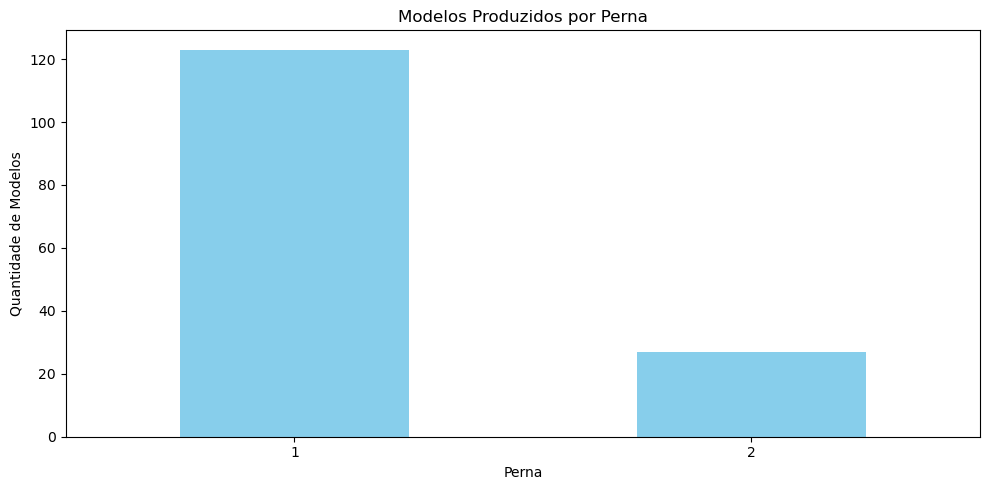

C:\Users\User\AppData\Local\Temp\ipykernel_5276\3497704547.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_5276\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_5276\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_5276\4282426640.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


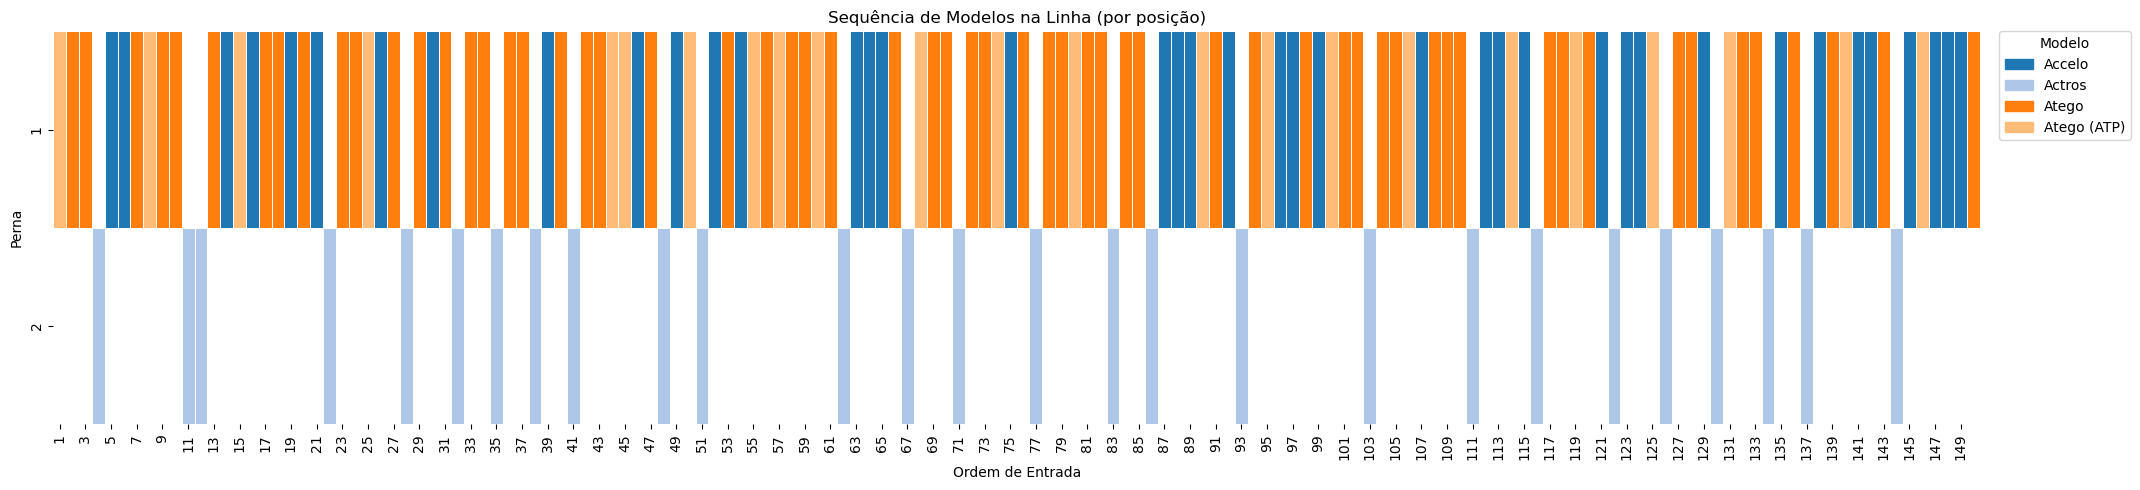

📁 Log salvo em: logs_ATUAL/2025-04-10/log_2025-04-10.csv
📝 PDF salvo em: logs_ATUAL/2025-04-10/resumo_simulacao.pdf

🔄 Processando o dia: 2025-04-11


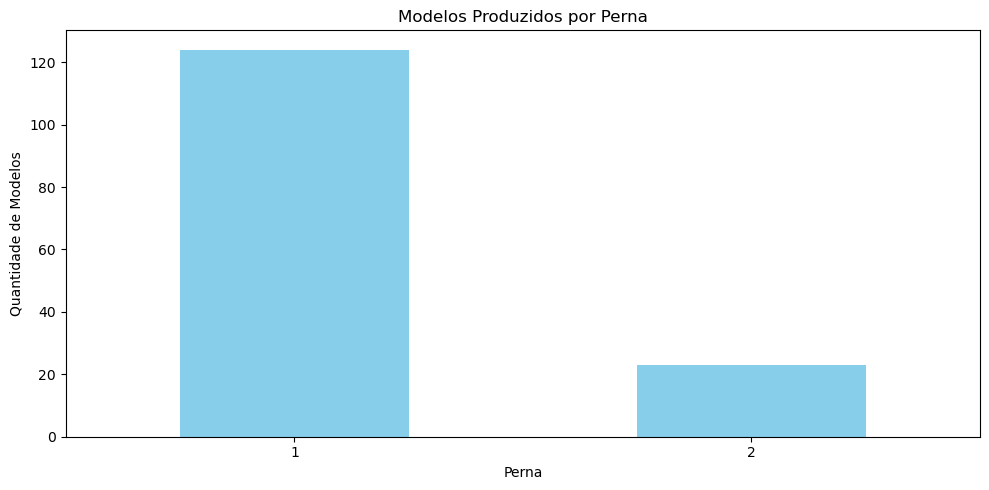

C:\Users\User\AppData\Local\Temp\ipykernel_5276\3497704547.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_5276\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_5276\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_5276\4282426640.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


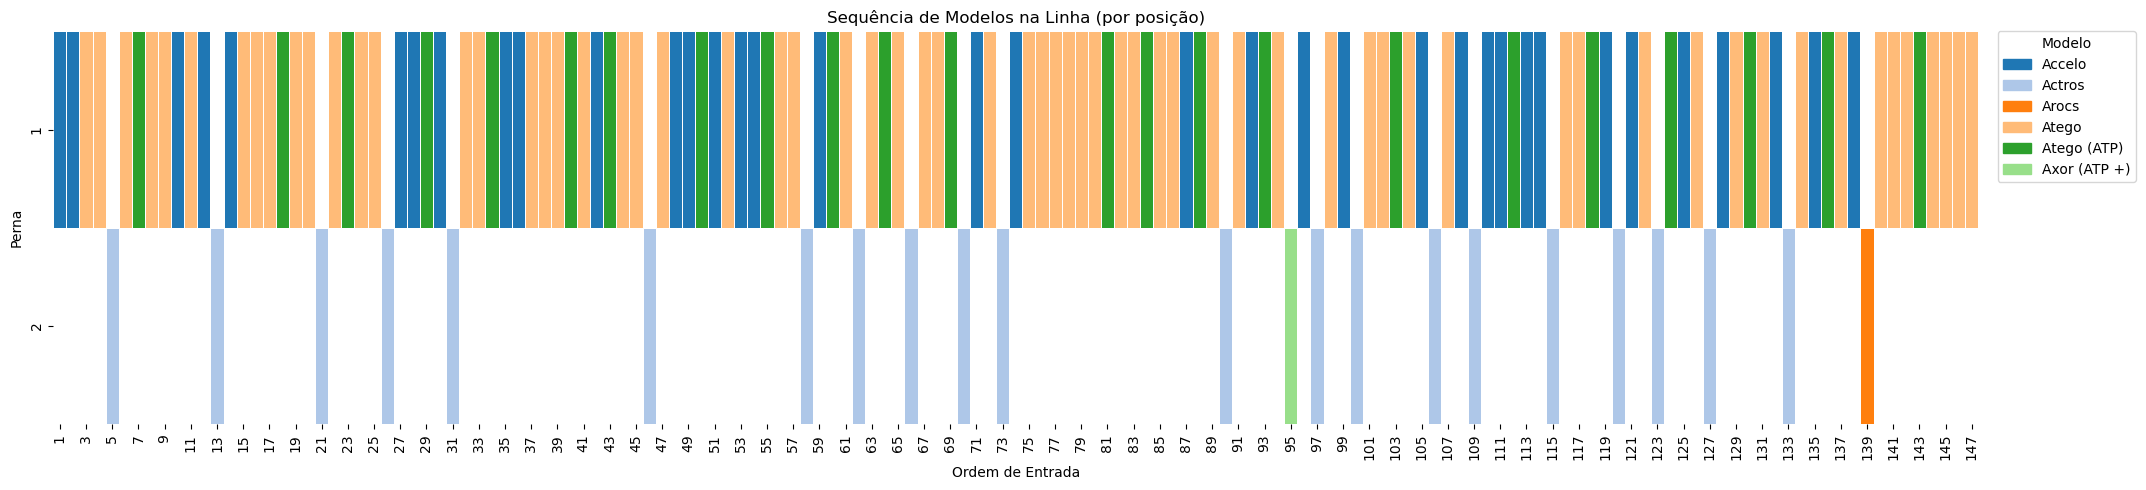

📁 Log salvo em: logs_ATUAL/2025-04-11/log_2025-04-11.csv
📝 PDF salvo em: logs_ATUAL/2025-04-11/resumo_simulacao.pdf

🔄 Processando o dia: 2025-04-14


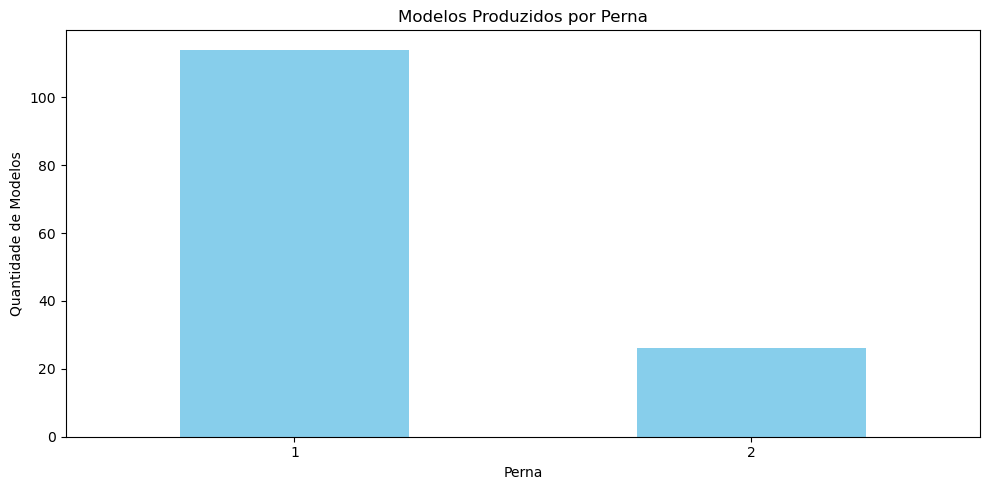

C:\Users\User\AppData\Local\Temp\ipykernel_5276\3497704547.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_5276\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_5276\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_5276\4282426640.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


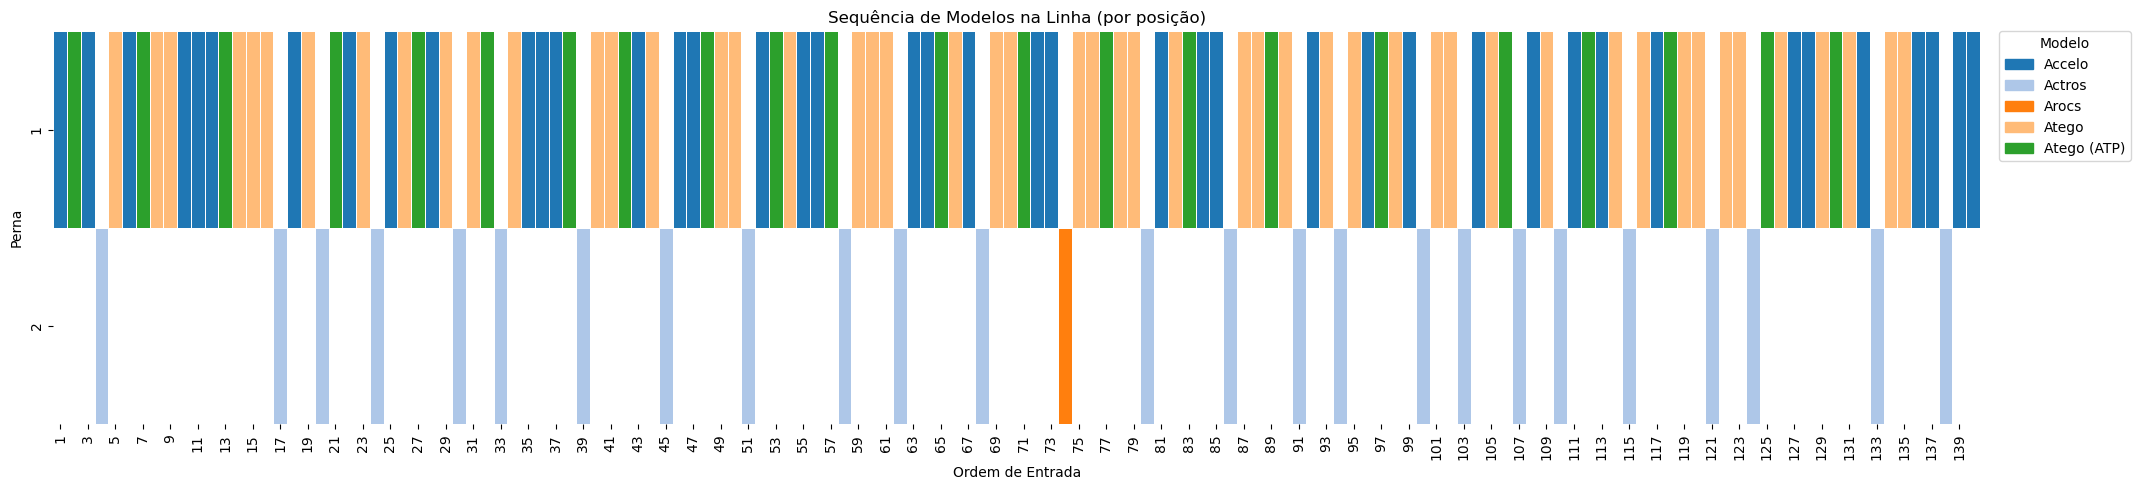

📁 Log salvo em: logs_ATUAL/2025-04-14/log_2025-04-14.csv
📝 PDF salvo em: logs_ATUAL/2025-04-14/resumo_simulacao.pdf

🔄 Processando o dia: 2025-04-15


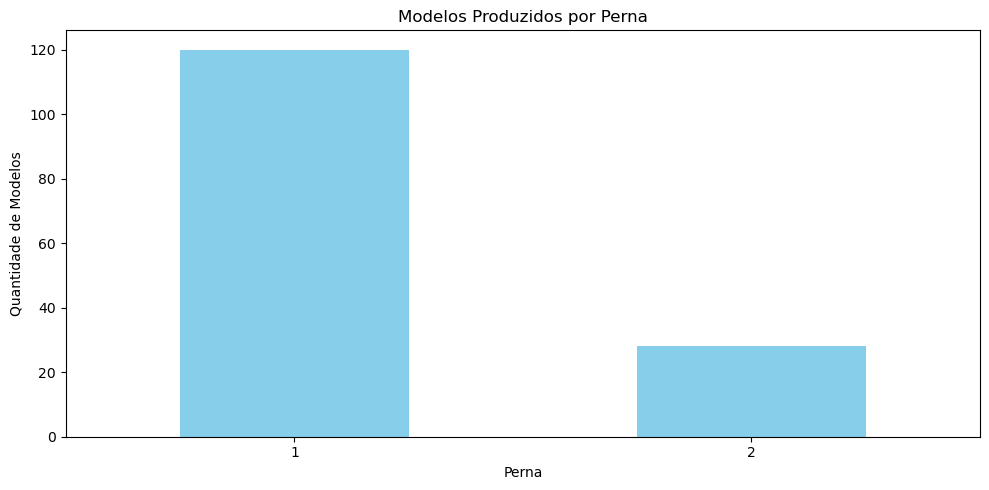

C:\Users\User\AppData\Local\Temp\ipykernel_5276\3497704547.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_5276\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_5276\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_5276\4282426640.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


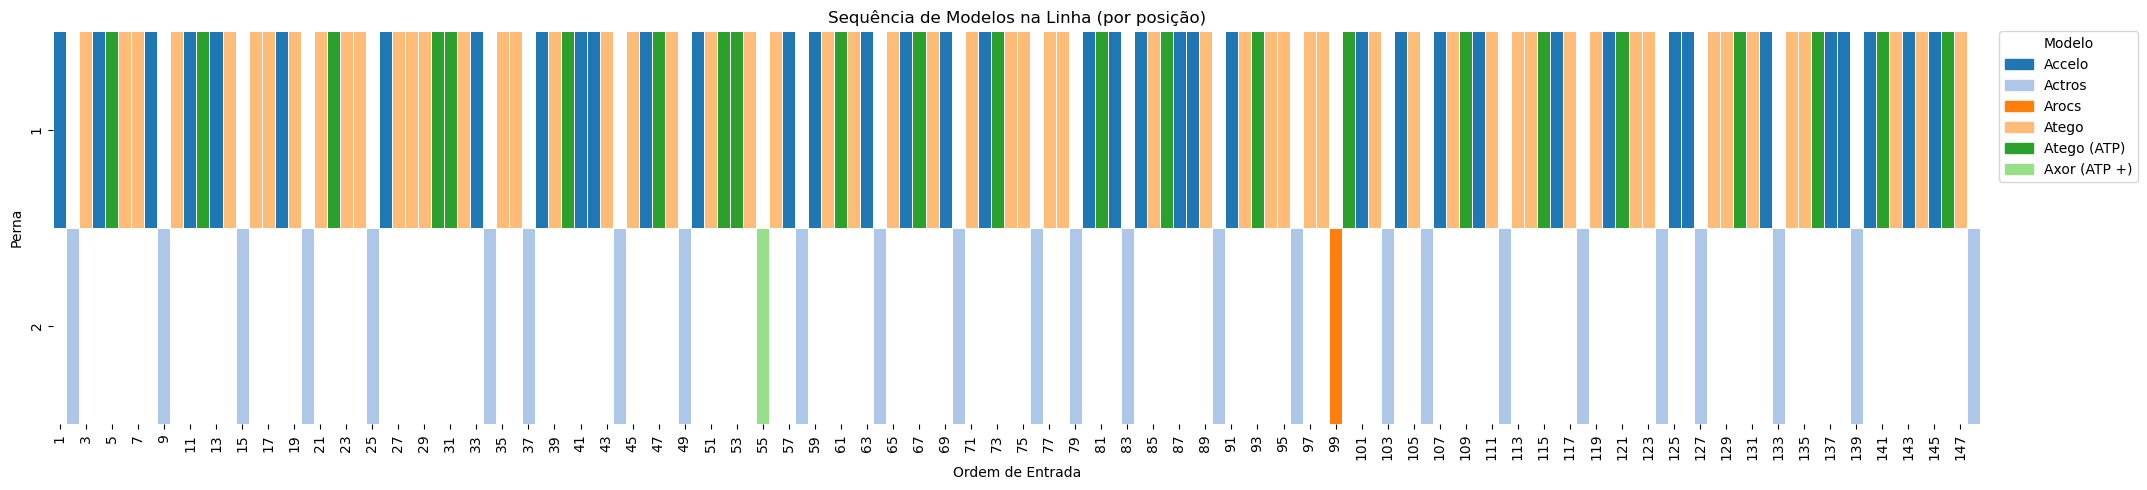

📁 Log salvo em: logs_ATUAL/2025-04-15/log_2025-04-15.csv
📝 PDF salvo em: logs_ATUAL/2025-04-15/resumo_simulacao.pdf

🔄 Processando o dia: 2025-04-16


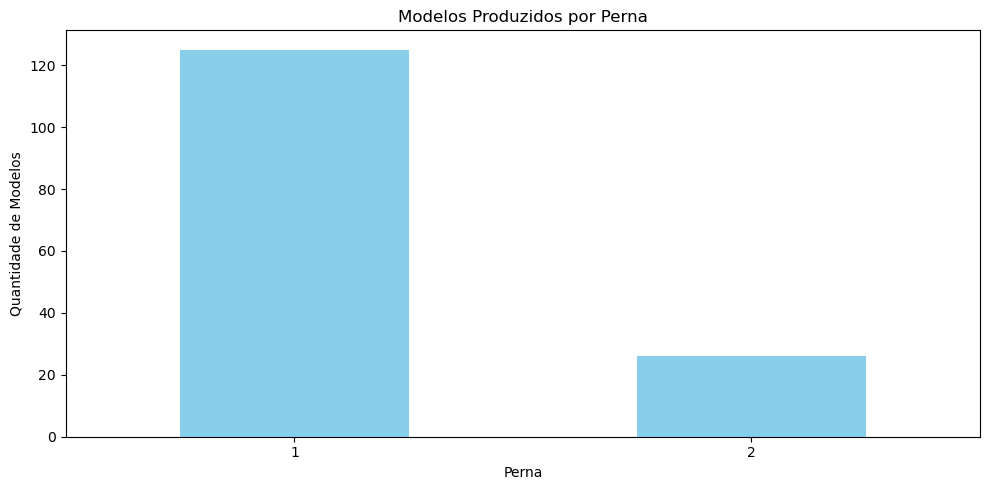

C:\Users\User\AppData\Local\Temp\ipykernel_5276\3497704547.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_5276\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_5276\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_5276\4282426640.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


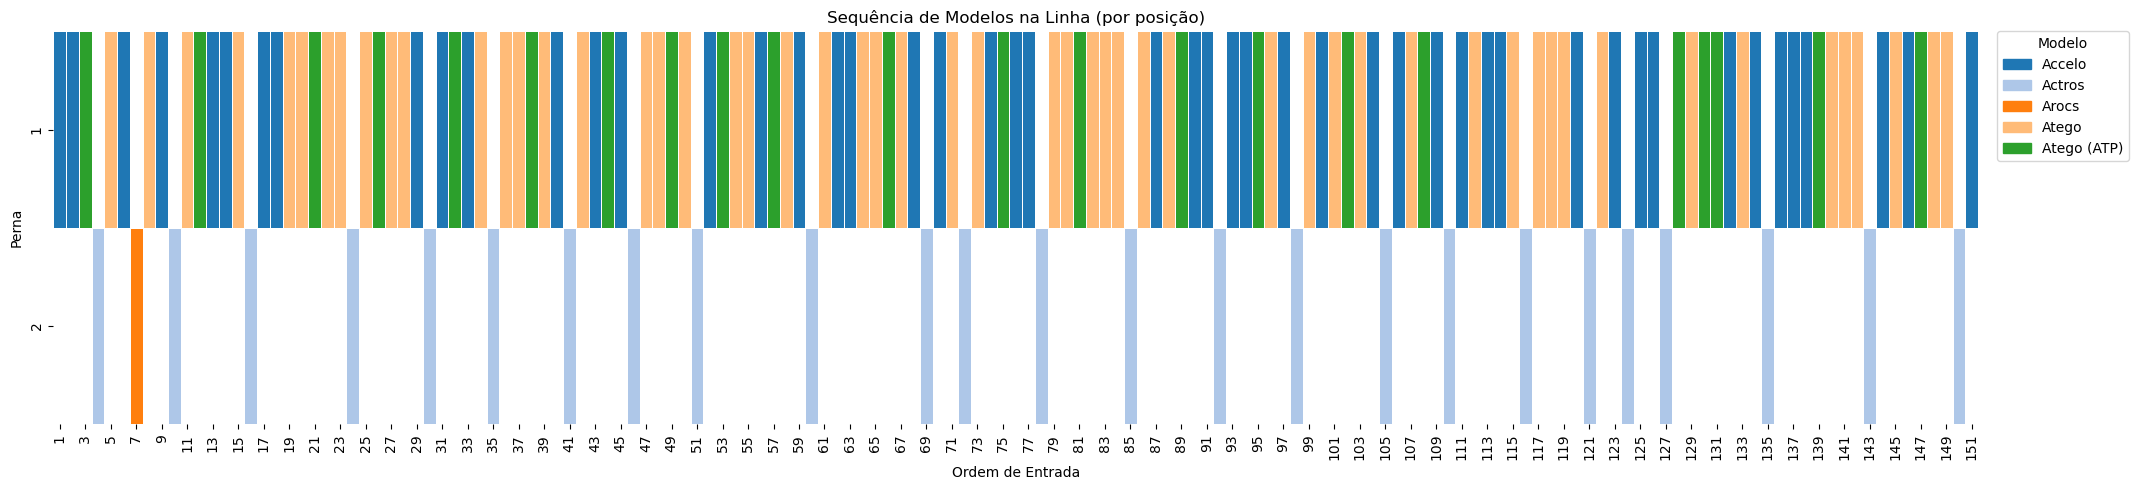

📁 Log salvo em: logs_ATUAL/2025-04-16/log_2025-04-16.csv
📝 PDF salvo em: logs_ATUAL/2025-04-16/resumo_simulacao.pdf


In [17]:

# Lê o arquivo Excel com os dados de produção
df_sequencia = pd.read_excel("sequencias_entrada_linha.xlsx")

# Converte a coluna de data/hora
df_sequencia['Data Entrada Linha'] = pd.to_datetime(df_sequencia['Data Entrada Linha'], errors='coerce')

# Define data de início (ajuste conforme necessário!)
data_inicio = date(2025, 4, 10)

# Obtém os dias únicos ordenados
dias_unicos = sorted(df_sequencia['Data Entrada Linha'].dt.date.dropna().unique())
# Filtra os dias a partir da data de início e pega os N primeiros
N_DIAS = 5
dias_filtrados = [d for d in dias_unicos if d >= data_inicio][:N_DIAS]


print(f"🗓️ Dias selecionados ({N_DIAS} a partir de {data_inicio}):")
for d in dias_filtrados:
    print(f"  - {d}")

# Cria pasta principal se não existir
os.makedirs("logs_ATUAL", exist_ok=True)

# Salvando tempo por atividades
# figs = plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv)
# for i, fig in enumerate(figs, start=1):
#     fig.savefig(f"logs_ATUAL/atividades_modelo{i}.png", dpi=300, bbox_inches="tight")
#     plt.close(fig)

# Loop por dia
for dia in dias_filtrados:
    log_entrada_saida = []
    print(f"\n🔄 Processando o dia: {dia}")
    
    pasta_dia = f"logs_ATUAL/{dia}"
    nome_csv = f"{pasta_dia}/log_{dia}.csv"

    # # Se já tiver o CSV salvo, pula o dia
    # if os.path.exists(nome_csv):
    #     print(f"✅ Já processado: {dia}")
    #     continue

    os.makedirs(pasta_dia, exist_ok=True)

    # --------- 🔧 AQUI ESTÁ A MUDANÇA IMPORTANTE ---------
    # Filtra dados do dia e ORDENA por Data Entrada Linha (data+hora)
    df_dia = (
        df_sequencia[df_sequencia['Data Entrada Linha'].dt.date == dia]
        .copy()
        .sort_values('Data Entrada Linha', ascending=True)
    )

    # Extrai os 7 primeiros dígitos do Baumuster (removendo espaços perdidos)
    df_dia['Baumuster_7dig'] = df_dia['Baumuster'].astype(str).str.strip().str[:7]

    # Agora a sequência está na ordem correta (crescente por horário daquele dia)
    sequencia_modelos = df_dia['Baumuster_7dig'].tolist()
    # sequencia_modelos = ['C951104']
    # ------------------------------------------------------
    
    # (Opcional) print de conferência
    # print("Primeiros registros do dia ordenados:")
    # print(df_dia[['Data Entrada Linha', 'Baumuster', 'Baumuster_7dig']].head(10))

    # Simula
    df_log = simulacao_linha(sequencia_modelos, MODELOS_CSV, POSTOS, TAKT_TIME, TURN_DURATION)

    # Gráficos e salvamento
    fig1 = plot_modelos_por_perna(df_log)
    fig1.savefig(f"{pasta_dia}/modelos_por_perna.png", dpi=300, bbox_inches="tight")
    plt.close(fig1)

    fig2 = plot_modelos_produzidos(df_log)
    fig2.savefig(f"{pasta_dia}/modelos_produzidos.png", dpi=300, bbox_inches="tight")
    plt.close(fig2)

    figs = plot_ocupacao_por_modelo_heatmap(df_log, TURN_DURATION)
    for i, fig in enumerate(figs, start=1):
        fig.savefig(f"{pasta_dia}/ocupacao_modelo_posto_P{i}.png", dpi=300, bbox_inches="tight")
        plt.close(fig)
    
    figs = plot_duracao_media_por_posto(df_log)
    for i, fig in enumerate(figs, start=1):
        fig.savefig(f"{pasta_dia}/duracao_media_por_posto_P{i}.png", dpi=300, bbox_inches="tight")
        plt.close(fig)

    fig5 = plot_sequencia_modelos_heatmap(df_log)
    fig5.savefig(f"{pasta_dia}/sequencia_dia.png", dpi=300, bbox_inches='tight')
    plt.close(fig5)

    # fig6 = plot_boxplot_tempo_total_por_modelo(df_log)
    # fig6.savefig(f"{pasta_dia}/boxplot_tempo_total_por_modelo.png", dpi=300, bbox_inches='tight')
    # plt.close(fig6)

    # Salva CSV com o log
    df_log.to_csv(nome_csv, index=False)
    print(f"📁 Log salvo em: {nome_csv}")

    # (Opcional) Salva PDF com o resumo
    caminho_pdf = f"{pasta_dia}/resumo_simulacao.pdf"
    gerar_resumo_pdf(df_log, TURN_DURATION, caminho_pdf)